<a href="https://colab.research.google.com/github/anhpham3621/Portfolio_Optimization_SP25/blob/main/(CV)_Optimization_final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization


In [ ]:
# license_uuid="46fa0cd4-c02d-437c-8da5-7bb4124f8e6f".

In [ ]:
# The only 3 lines you need to install and use AMPL with any solver on Colab
%pip install -q amplpy pandas matplotlib seaborn
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="your-license-uuid",  # license to use
)  # instantiate AMPL object and register magics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 22.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
assets = df = pd.DataFrame(
    {
        "Expected_return": [0.1367, 0.00069, 0.2445, 0.1131, 0.1037, 0.2413, 0.1299, 0.2788, 0.137, -0.0485],
        "Risk": [0.0823, 0.1174, 0.0232, 0.0026, 0.0467, 0.0149, 0.0417, 0.0102, 0.0139, 0.0997],
        "Sector": ["Tech", "Consumer Disc", "Tech", "Industrial", "Health", "Finance", "Consumer Disc", "Finance", "Industrial", "Consumer Disc"],
    },
    index=["AMZ", "DIS", "AAPL", "BA", "UNH", "JPM", "HD", "GS", "KO", "NKE"],
  )


We consider two variations of the portfolio optimization model, both using the same base dataset of assets (with expected returns and risk values) but differing in how sector constraints are handled.

##Version 1: Unconstrained Sector Allocation

This version places no restrictions on the minimum or maximum investment in any sector. We want to find the optimal asset allocation that minimizes risk purely based on asset-level characteristics, allowing the optimizer to freely allocate across all sectors.

This serves as a baseline for comparison.

In [ ]:
%%writefile portfolio1.mod
# Portfolio Optimization - Version 1: No Sector Constraints

set ASSETS;

param ExpectedReturn{ASSETS};
param Risk{ASSETS};
param TargetReturn;

var w{ASSETS} >= 0;  # No short-selling allowed

# Objective: Minimize risk
minimize TotalRisk:
    sum {a in ASSETS} Risk[a] * w[a];

# Ensure the expected return meets target
subject to ReturnConstraint:
    sum {a in ASSETS} ExpectedReturn[a] * w[a] >= TargetReturn;

# Ensure total investment sums to 1
subject to TotalWeight:
    sum {a in ASSETS} w[a] = 1;


Overwriting portfolio1.mod


In [ ]:
ampl = AMPL()

# Load the model without sector constraints
ampl.read("portfolio1.mod")

# Load asset data
ampl.set["ASSETS"] = assets.index.tolist()
ampl.param["ExpectedReturn"] = assets["Expected_return"].to_dict()
ampl.param["Risk"] = assets["Risk"].to_dict()
ampl.param["TargetReturn"] = 0.20

# Solve the optimization problem
ampl.solve(solver="gurobi")

assert ampl.solve_result == "solved"

# Extract the optimal weights into a DataFrame
weights = ampl.get_variable("w").to_pandas()
print(weights)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.006585757393
1 simplex iteration
         w.val
AAPL  0.000000
AMZ   0.000000
BA    0.475558
DIS   0.000000
GS    0.524442
HD    0.000000
JPM   0.000000
KO    0.000000
NKE   0.000000
UNH   0.000000


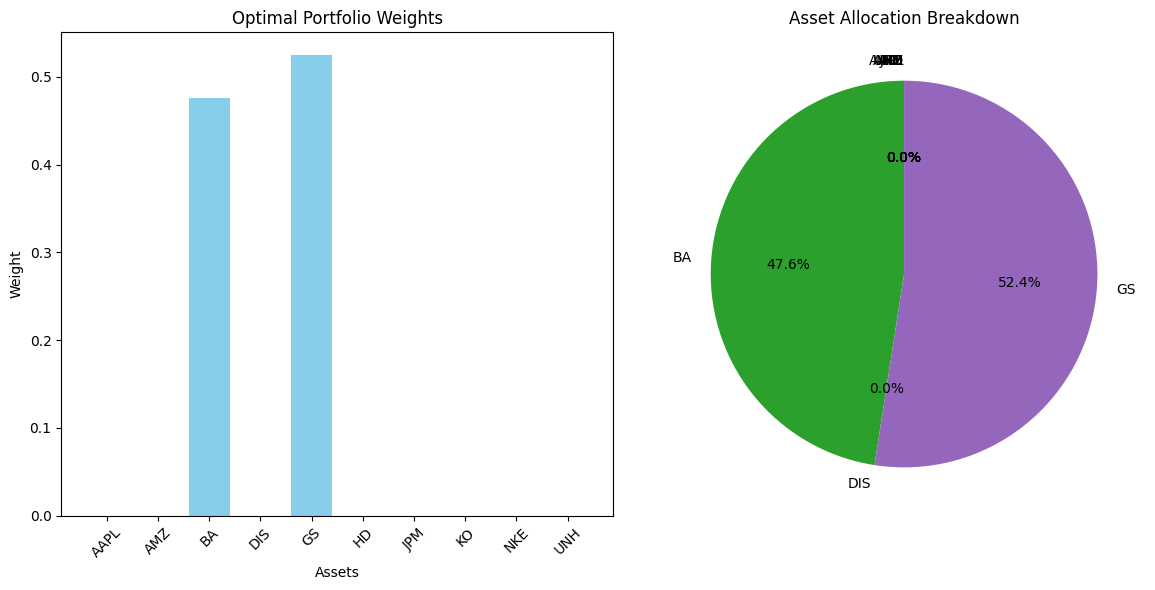

In [ ]:
weights = ampl.get_variable("w").to_pandas()["w.val"]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot
ax1.bar(weights.index, weights.values, color="skyblue")
ax1.set_title("Optimal Portfolio Weights")
ax1.set_xlabel("Assets")
ax1.set_ylabel("Weight")
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(weights.values, labels=weights.index, autopct='%1.1f%%', startangle=90)
ax2.set_title("Asset Allocation Breakdown")

plt.tight_layout()
plt.show()

## Version 2: Sector-Constrained Portfolio Optimization

In this version, we extend the base portfolio optimization model by introducing **sector-level constraints** and **individual asset** constraints. Specifically, we impose both minimum and maximum thresholds on how much of the total portfolio can be invested in each sector. We also impose a limit on the  percentage a single asset can be alloted.

By bounding sector exposure, we explore how such constraints influence the optimal asset allocation compared to the unconstrained version. The goal is to balance risk and return while ensuring no sector is overly dominant or underrepresented in the final portfolio.

In [ ]:
%%writefile portfolio2.mod
# Portfolio Optimization - Version 2: Sector Min & Max Constraints

set ASSETS;
set SECTORS;

param ExpectedReturn{ASSETS};
param Risk{ASSETS};
param TargetReturn;
param Sector{ASSETS} symbolic;
# Maximum weight for any single asset
param MaxAssetWeight := 0.30;

# Min and max weight allowed for each sector
param MinSectorWeight{SECTORS};
param MaxSectorWeight{SECTORS};

var w{ASSETS} >= 0;  # No short-selling allowed

# Objective: Minimize total portfolio risk
minimize TotalRisk:
    sum {a in ASSETS} Risk[a] * w[a];

# Ensure portfolio meets target return
subject to ReturnConstraint:
    sum {a in ASSETS} ExpectedReturn[a] * w[a] >= TargetReturn;

# Total weight must equal 1
subject to TotalWeight:
    sum {a in ASSETS} w[a] = 1;

# Enforce sector-specific minimums
subject to SectorMin {s in SECTORS}:
    sum {a in ASSETS: Sector[a] = s} w[a] >= MinSectorWeight[s];

# Enforce sector-specific maximums
subject to SectorMax {s in SECTORS}:
    sum {a in ASSETS: Sector[a] = s} w[a] <= MaxSectorWeight[s];

# Constraint to limit the maximum weight of any single asset
subject to MaxWeightConstraint {a in ASSETS}:
    w[a] <= MaxAssetWeight;

Overwriting portfolio2.mod


In [ ]:
ampl = AMPL()

ampl.read("portfolio2.mod")

ampl.set["ASSETS"] = assets.index.tolist()
ampl.set["SECTORS"] = list(assets["Sector"].unique())

ampl.param["ExpectedReturn"] = assets["Expected_return"].to_dict()
ampl.param["Risk"] = assets["Risk"].to_dict()
ampl.param["TargetReturn"] = 0.20           # 20% return
ampl.param["Sector"] = {k: str(v) for k, v in assets["Sector"].items()}


sector_list = assets["Sector"].unique()
min_weights = {sector: 0.10 for sector in sector_list}  # 10% minimum per sector
max_weights = {sector: 0.50 for sector in sector_list}  # 50% maximum per sector

ampl.param["MinSectorWeight"] = min_weights
ampl.param["MaxSectorWeight"] = max_weights


ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved"

# Extract weights
weights = ampl.get_variable("w").to_pandas()
print(weights)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.01749645086
4 simplex iterations
         w.val
AAPL  0.100000
AMZ   0.000000
BA    0.218175
DIS   0.000000
GS    0.300000
HD    0.100000
JPM   0.181825
KO    0.000000
NKE   0.000000
UNH   0.100000


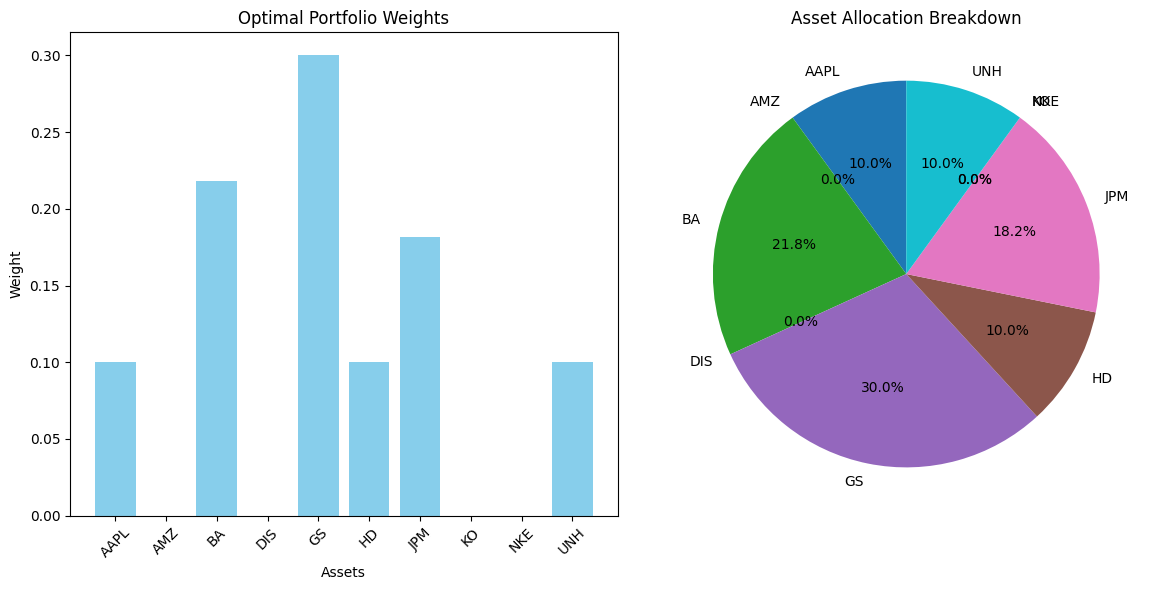

In [ ]:
weights = ampl.get_variable("w").to_pandas()["w.val"]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot
ax1.bar(weights.index, weights.values, color="skyblue")
ax1.set_title("Optimal Portfolio Weights")
ax1.set_xlabel("Assets")
ax1.set_ylabel("Weight")
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(weights.values, labels=weights.index, autopct='%1.1f%%', startangle=90)
ax2.set_title("Asset Allocation Breakdown")

plt.tight_layout()
plt.show()

### Sector Allotment Visualization

In [ ]:
weights_df = weights.rename("Weight")

# Add a 'Sector' column using the original assets DataFrame
weights_df = pd.DataFrame(weights_df)
weights_df["Sector"] = assets.loc[weights_df.index, "Sector"] # Extract sector info

# Calculate total weight per sector
sector_weights = weights_df.groupby("Sector")["Weight"].sum()

<ipython-input-26-578638f71239>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


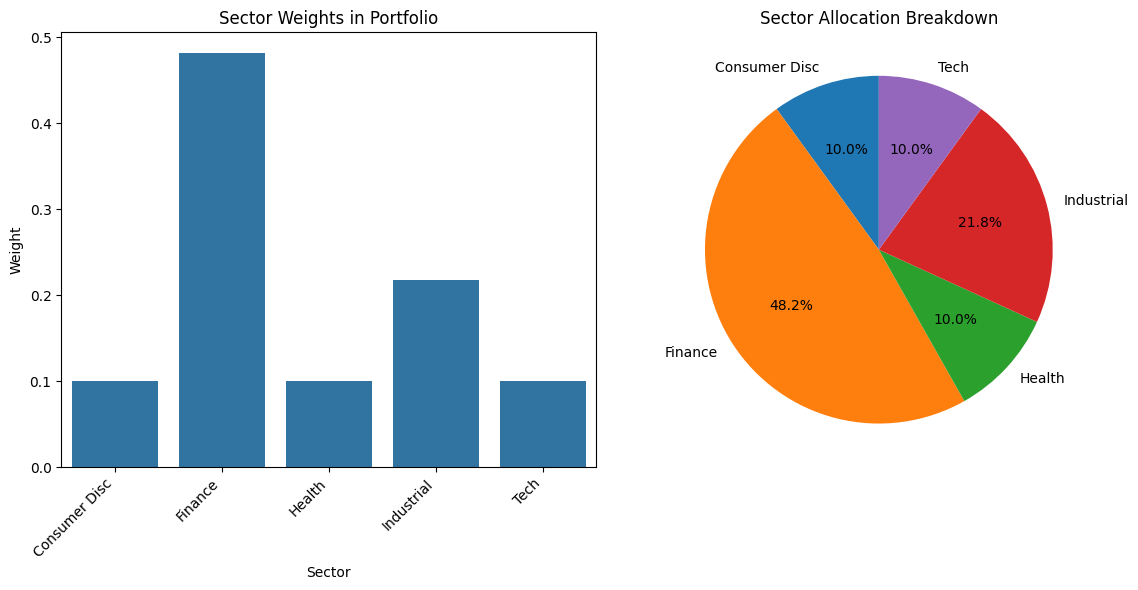

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot on the left (ax1)
sns.barplot(x=sector_weights.index, y=sector_weights.values, ax=ax1)
ax1.set_title("Sector Weights in Portfolio")
ax1.set_xlabel("Sector")
ax1.set_ylabel("Weight")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# Pie chart on the right (ax2)
ax2.pie(sector_weights.values, labels=sector_weights.index, autopct='%1.1f%%', startangle=90)
ax2.set_title("Sector Allocation Breakdown")


plt.tight_layout()
plt.show()

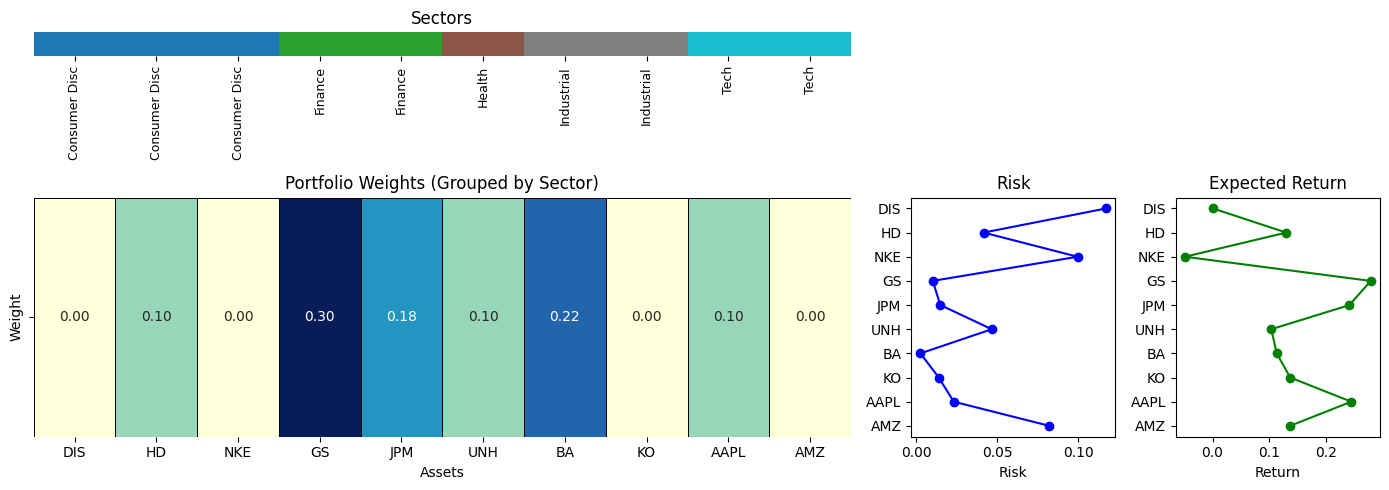

In [ ]:
weights_sorted = weights.sort_index() # Sort by assets

weights_sorted = weights_sorted.to_frame(name='Weight') # Convert to dataframe
weights_sorted['Sector'] = assets.loc[weights_sorted.index, "Sector"]

# Add 'Risk' and 'ExpectedReturn' columns to weights_sorted
weights_sorted['Risk'] = assets.loc[weights_sorted.index, "Risk"]
weights_sorted['ExpectedReturn'] = assets.loc[weights_sorted.index, "Expected_return"]
weights_sorted = weights_sorted.sort_values(by=['Sector'])


df_weights = weights_sorted[["Weight"]].T
df_weights.columns = weights_sorted.index

#  Get sector info and encode as numeric
sectors_sorted = weights_sorted["Sector"]
unique_sectors = sectors_sorted.unique()
sector_to_color_idx = {sector: i for i, sector in enumerate(unique_sectors)}
sector_numeric = sectors_sorted.map(sector_to_color_idx)  # numeric codes for cmap

# Plot
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(ncols=3, nrows=2, width_ratios=[10, 2.5, 2.5], height_ratios=[0.4, 4])

ax_sector = fig.add_subplot(gs[0, 0])      # top sector color bar
ax_heatmap = fig.add_subplot(gs[1, 0])     # main heatmap
ax_risk = fig.add_subplot(gs[1, 1])
ax_return = fig.add_subplot(gs[1, 2])

# --- Sector Color Bar ---
# 2D array with shape (1, num_assets), values = numeric codes
sns.heatmap([sector_numeric.values], ax=ax_sector, cmap="tab10", cbar=False,
            xticklabels=weights_sorted.index, yticklabels=False)
ax_sector.set_xticklabels(sectors_sorted, rotation=90, fontsize=9)
ax_sector.set_title("Sectors", fontsize=12)
ax_sector.tick_params(left=False)

# --- Portfolio Weights Heatmap ---
sns.heatmap(df_weights, ax=ax_heatmap, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
            linewidths=0.5, linecolor="black")
ax_heatmap.set_title("Portfolio Weights (Grouped by Sector)")
ax_heatmap.set_xlabel("Assets")
ax_heatmap.set_ylabel("")

# --- Risk Plot ---
ax_risk.plot(weights_sorted["Risk"], weights_sorted.index, marker='o', linestyle='-', color='blue')
ax_risk.set_title("Risk")
ax_risk.set_xlabel("Risk")
ax_risk.set_ylabel("")
ax_risk.invert_yaxis()

# --- Expected Return Plot ---
ax_return.plot(weights_sorted["ExpectedReturn"], weights_sorted.index, marker='o', linestyle='-', color='green')
ax_return.set_title("Expected Return")
ax_return.set_xlabel("Return")
ax_return.set_ylabel("")
ax_return.invert_yaxis()

plt.tight_layout()
plt.show()